# Tutorial 6: Horizontal integration

In this tutorial, we demonstrate how to analyse multiple tissue slices in horizontal integration. Here we take mouse anterior and posterior brain as example. Before running the model, please download the input data via https://zenodo.org/record/8185216/files/Mouse_brain.rar?download=1.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import time
import stGCL as stGCL
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels,vertical_alignment
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import train_model
from stGCL.utils import mclust_R,Cal_Spatial_Net
import anndata as ad
import torch

In [2]:
rad_cutoff = 120
seed=0
set_seed(seed)
k = 26
top_genes = 3000
epoch = 1200
section_id="V1_Mouse_Brain_Sagittal"

In [3]:
adata_a = sc.read_visium("/home/dell/stproject/stGCL/Data/Mouse_brain/V1_Mouse_Brain_Sagittal_Anterior_Section_1",
                       count_file="V1_Mouse_Brain_Sagittal_Anterior_Section_1_filtered_feature_bc_matrix.h5")
spatial_a=pd.read_csv("/home/dell/stproject/stGCL/Data/Mouse_brain/V1_Mouse_Brain_Sagittal_Anterior_Section_1/spatial/tissue_positions_list.csv",
                    sep=",",header=None,na_filter=False,index_col=0)
adata_a.obs["x_array"]=spatial_a[2]
adata_a.obs["y_array"]=spatial_a[3]
adata_a.obs["x_pixel"]=spatial_a[4]
adata_a.obs["y_pixel"]=spatial_a[5]

im_re_a = pd.read_csv("/home/dell/stproject/stGCL/Data/Mouse_brain/V1_Mouse_Brain_Sagittal_Anterior_Section_1/"
                    "image_representation/ViT_pca_representation.csv", header=0, index_col=0, sep=',')
adata_a.obsm["im_re"] = im_re_a

In [4]:
adata_p = sc.read_visium("/home/dell/stproject/stGCL/Data/Mouse_brain/V1_Mouse_Brain_Sagittal_Posterior_Section_1",
                       count_file="V1_Mouse_Brain_Sagittal_Posterior_Section_1_filtered_feature_bc_matrix.h5")
spatial_p=pd.read_csv("/home/dell/stproject/stGCL/Data/Mouse_brain/V1_Mouse_Brain_Sagittal_Posterior_Section_1/spatial/tissue_positions_list.csv",
                    sep=",",header=None,na_filter=False,index_col=0)
adata_p.obs["x_array"]=spatial_p[2]
adata_p.obs["y_array"]=spatial_p[3]
adata_p.obs["x_pixel"]=spatial_p[4]
adata_p.obs["y_pixel"]=spatial_p[5]
im_re_p = pd.read_csv("/home/dell/stproject/stGCL/Data/Mouse_brain/V1_Mouse_Brain_Sagittal_Posterior_Section_1/"
                    "image_representation/ViT_pca_representation.csv", header=0, index_col=0, sep=',')
adata_p.obsm["im_re"] = im_re_p

## Horizontal alignment

In [5]:
obs_a=adata_a.obs
obs_p=adata_p.obs
# obs_p["x_pixel"]=obs_p["x_pixel"]-np.min(obs_p["x_pixel"])+np.min(obs_a["x_pixel"])
obs_p["y_pixel"]=obs_p["y_pixel"]-np.min(obs_p["y_pixel"])+np.max(obs_a["y_pixel"])
obs_a["boundary"]=0
obs_p["boundary"]=0

for i in list(set(obs_a['x_array'])):
    j=obs_a[obs_a['x_array']==i].max()["y_array"]
    temp=obs_a[obs_a['x_array']==i]
    temp = temp[temp['y_array']==j].index
    obs_a.loc[temp,"boundary"]=1

for i in list(set(obs_p['x_array'])):
    j=obs_p[obs_p['x_array']==i].min()["y_array"]
    temp=obs_p[obs_p['x_array']==i]
    temp = temp[temp['y_array']==j].index
    obs_p.loc[temp,"boundary"]=1

mean_a_y=obs_a[obs_a["boundary"]==1]['x_pixel'].mean()
mean_p_y=obs_p[obs_p["boundary"]==1]['x_pixel'].mean()
obs_p['x_pixel']=obs_p['x_pixel']+mean_a_y-mean_p_y

In [6]:
adata_a.var_names_make_unique()
adata_p.var_names_make_unique()
adata_all=ad.AnnData.concatenate(adata_a, adata_p,join='inner',batch_key="dataset_batch",batch_categories=["Anterior","Posterior"])
adata_all.var_names_make_unique()
adata_all.obsm["spatial"] = adata_all.obs.loc[adata_all.obs_names, ['x_pixel', "y_pixel"]].to_numpy()

In [7]:
prefilter_genes(adata_all, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata_all)
sc.pp.highly_variable_genes(adata_all, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)
sc.pp.scale(adata_all, zero_center=False, max_value=10)

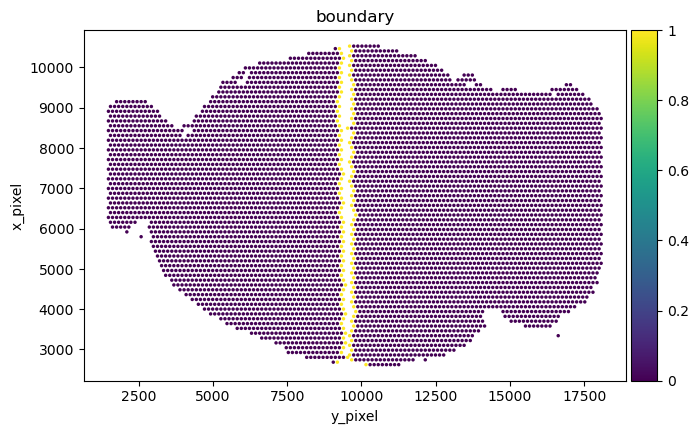

In [10]:
%matplotlib inline
ax=sc.pl.scatter(adata_all,alpha=1,x="y_pixel",y="x_pixel",color="boundary",show=True,size=150000/adata_all.shape[0])

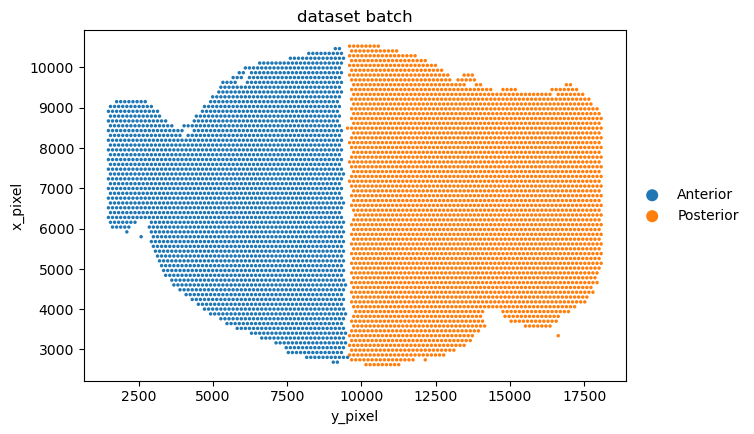

In [11]:
ax=sc.pl.scatter(adata_all,alpha=1,x="y_pixel",y="x_pixel",color="dataset_batch",show=True,size=150000/adata_all.shape[0])

## Constructing the spatial network and Running model

In [12]:
Cal_Spatial_Net(adata_all, rad_cutoff=120)

In [13]:
adata_ap= train_model.train(adata_all, k, n_epochs=epoch, use_image=True,single=False,device=torch.device('cuda:0'))

train with image
Epoch:100 loss:0.7354
Epoch:200 loss:0.68354
Epoch:300 loss:0.66821
Epoch:400 loss:0.65987
Epoch:500 loss:0.65341
Epoch:600 loss:0.64939
Epoch:700 loss:0.64543
Epoch:800 loss:0.64436
Epoch:900 loss:0.6409
Epoch:1000 loss:0.63938
Epoch:1100 loss:0.64075
Epoch:1200 loss:0.63743


In [14]:
adata_ap = mclust_R(adata_ap, used_obsm='stGCL', num_cluster=k)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


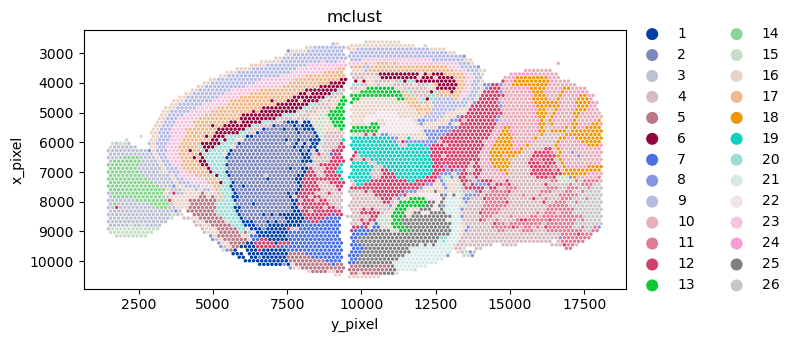

In [15]:
import matplotlib.pyplot as plt
title = "stGCL"
ax=sc.pl.scatter(adata_ap,alpha=1,x="y_pixel",y="x_pixel",color="mclust",show=False,size=150000/adata_all.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()